- Aluno: Vítor Gabriel Reis Caitité
- Matrícula: 2021712430


# Implementação de um Sistema de Inferência Neuro-Fuzzy Adaptativo (ANFIS)


Nesta etapa será implementada o sistema de inferência
neuro-fuzzy adaptativo, cuja sua rede neuro-fuzzy está ilustrada abaixo:

<p align="center">
  <img src="neurofuzzy_network.png" width="700"/>
</p>


In [16]:
from matplotlib import pyplot as plt
import numpy as np
from math import *
from sklearn.metrics import mean_squared_error
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import collections
import pandas as pd

In [2]:
class Anfis:
    def __init__(self, n_rules, n_inputs):
        self.n_rules = n_rules
        self.n_inputs = n_inputs
        self.c = np.zeros([self.n_inputs, self.n_rules])   
        self.s = np.zeros([self.n_inputs, self.n_rules])
        self.P = np.random.randn(self.n_inputs, self.n_rules)
        self.q = np.random.randn(self.n_rules)
        
    def initialize_params(self, X):
        for i in range(self.n_inputs):
            delta = ((X[:,i].max() - X[:,i].min())/(self.n_rules-1))
            for rule in range(self.n_rules):
                self.s[i,rule] = delta/(2*sqrt(log(4)))
                self.c[i, rule] = X[:,i].min() + (rule * delta)
            
    def forward(self, x, n_samples):
        y_hat = np.zeros(n_samples)
        for k in range(n_samples):
            w = np.zeros(self.n_rules)
            y = np.zeros(self.n_rules)
            for rule in range(self.n_rules):
                mu = np.zeros(self.n_inputs)
                y_ = self.q[rule]
                for i in range(self.n_inputs):
                    mu[i] = np.exp(-0.5*((x[k,i]-self.c[i,rule])/self.s[i,rule])**2)
                    y_ += self.P[i, rule] * x[k, i]
                w[rule] = np.product(mu, axis = 0)
                y[rule] = y_
            b = np.sum(w)
            a = np.sum(y*w)
            y_hat[k] = a/b
        return y_hat, b, w, y
    
    # X - dados de entrada
    # y - saídas esperadas
    # n_epochs - maximo de épocas
    # lr - learning rate
    def fit(self, X, y_real, n_epochs=100, lr=0.1):
        self.mse = []
        # Estrutura de repetição para número de épocas
        for epoch in range(n_epochs):
            # Estrutura de repetição para o números de pontos
            for k in range(X.shape[0]):
                # Apresentação dos dados a rede e cálculo da saída para os parâmetros atuais
                y_hat, b, w, y = self.forward(X[k:,:], 1)
                # Cálculo de derivadas (dedŷ, dyjdqj)
                de_dyhat = y_hat - y_real[k]
                dyj_dqj = 1
                
                dyhat_dwj = np.zeros(self.n_rules)
                dyhat_dyj = np.zeros(self.n_rules)
                # Estrutura de repetição para o número de regras
                for j in range(self.n_rules):
                    # Cálculo de derivadas (dŷdwj, dŷdyj)
                    dyhat_dwj[j] = (y[j] - y_hat)/b
                    dyhat_dyj[j] = w[j]/b
                    # Estrutura de repetição para número de entradas
                    for i in range(X.shape[1]):
                        # Cálculo de derivadas (dyjdPij, dwjdcij, dwjdsij)
                        dyj_dPij = X[k, i]
                        dwj_dcij = w[j] * (X[k, i] - self.c[i, j])/self.s[i, j]**2
                        dwj_dsij = w[j] * (X[k, i] - self.c[i, j])**2/self.s[i, j]**3
                        # Atualização de parâmetros (c, sigma, p)
                        self.c[i, j] = self.c[i, j] - lr * de_dyhat * dyhat_dwj[j] * dwj_dcij
                        self.s[i, j] = self.s[i, j] - lr * de_dyhat * dyhat_dwj[j] * dwj_dsij
                        self.P[i, j] = self.P[i, j] - lr * de_dyhat * dyhat_dyj[j] * dyj_dPij
                        #print(self.c[i, j])
                    # Atualização de parâmetro q
                    self.q[j] = self.q[j] - lr * de_dyhat * dyhat_dyj[j] * dyj_dqj
            # Atualização do valor de saída
            Y_hat, _, _ , _ = self.forward(X, X.shape[0])
            # Calculo do erro quadrático
            self.mse.append(mean_squared_error(y_real, Y_hat))
            
    def predict(self, X):
        y_hat, _, _, _ = self.forward(X, X.shape[0])
        return y_hat


# Problema 1 - Modelagem de sistema estático monovariável

Aproximar a função $y=x^2$.



## Geração dos Dados

In [104]:
# Generating Data
N = 1000
X = np.linspace(-2, 2, N).reshape(-1, 1)
y = X ** 2

## Aplicação do Anfis desenvolvido

mse: 0.00033430546315089374


Text(0, 0.5, 'MSE')

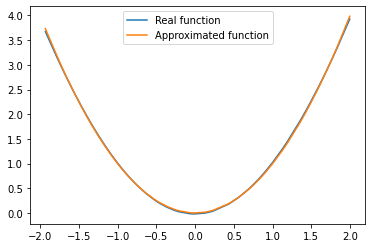

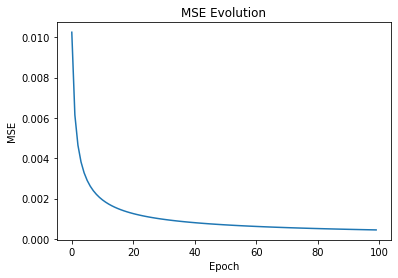

In [105]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Anfis
model = Anfis(n_rules = 2, n_inputs = 1)
model.initialize_params(X = X_train)
model.fit(X_train, y_train, n_epochs=100, lr=0.1)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
xx, yy = zip(*sorted(zip(X_test, yhat)))
plt.plot(xx, yy)
xx, yy = zip(*sorted(zip(X_test, y_test)))
plt.plot(xx, yy)
plt.legend(["Real function", "Approximated function"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 2 - Modelagem de sistema estático multivariável

Modelar uma função não linear de 3 entradas:

$output = (1+x^{0.5}+y^{-1}+z^{-1.5})^2$

## Geração dos dados:

Text(0.5, 1.0, '$Y_{test}$')

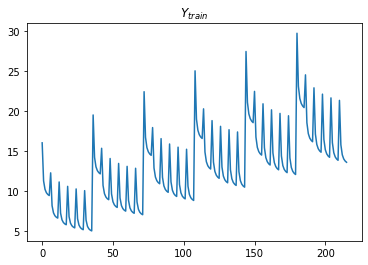

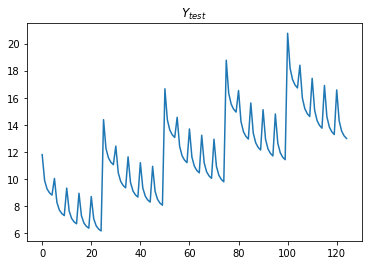

In [106]:
i = 0
X_train = []
y_train = []
X_test = []
y_test = []
for x1 in range(1, 7):
    for x2 in range(1, 7):
        for x3 in range(1, 7):
            X_train.append([x1, x2, x3])
            y_train.append((1 + x1**0.5 + x2**(-1) + x3**(-1.5))**2)
for x1 in range(1, 6):
    for x2 in range(1, 6):
        for x3 in range(1, 6):
            X_test.append([x1+0.5, x2+0.5, x3+0.5])
            y_test.append((1 + (x1+0.5)**0.5 + (x2+0.5)**(-1) + (x3+0.5)**(-1.5))**2)    
plt.plot(y_train)
plt.title("$Y_{train}$")
plt.figure()
plt.plot(y_test)
plt.title("$Y_{test}$")

## Aplicação do Anfis desenvolvido

mse: 0.23175302190917355


Text(0, 0.5, 'MSE')

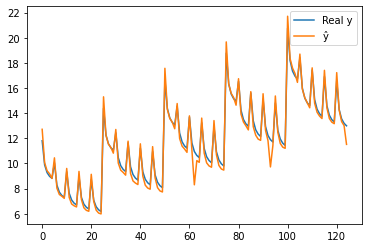

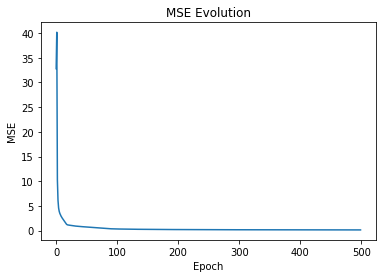

In [107]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Anfis
model = Anfis(10, X_train.shape[1])
model.initialize_params(X = X_train)
model.fit(X_train, y_train, n_epochs=500, lr=0.01)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 3 - Modelo de sistema dinâmico

##  Geração dos dados

In [123]:
def g(x):
    num = x[0] * x[1] * x[2] * x[4] * (x[2] - 1) + x[3]
    den = 1 + x[2]**2 + x[3]**2
    return num / den

In [124]:
K = np.linspace(0, 1000, 6000)
u = []
for k in K:
    if k<=500:
        u.append(np.sin(2*np.pi * k / 250))
    else:
        u.append(0.8 * (np.sin(2*np.pi * k / 250)) + 0.2 * np.sin(2*np.pi * k/25))

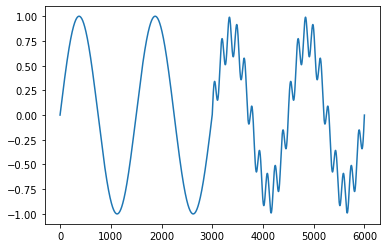

In [125]:
plt.plot(u)

In [126]:
X=[]
y=[]
x = [0, 0, 0, u[0], 0]
X.append(x)
y.append(g(x))
x = [g(x), y[0], 0, u[1], u[0]]
X.append(x)
y.append(g(x))
for k in range(2, 6000):
    x = [g(x), y[k-1], y[k-2], u[k], u[k-1]]
    X.append(x)
    y.append(g(x))
    
X = np.array(X)
y = np.array(y)

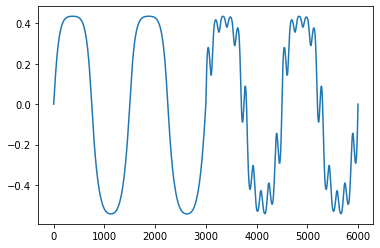

In [127]:
plt.plot(y)

## Aplicação do Anfis desenvolvido

mse: 1.0503485529821586e-05


Text(0, 0.5, 'MSE')

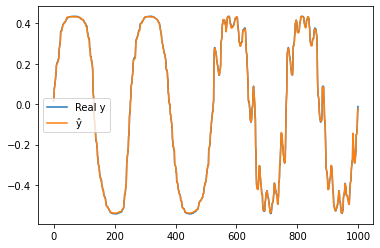

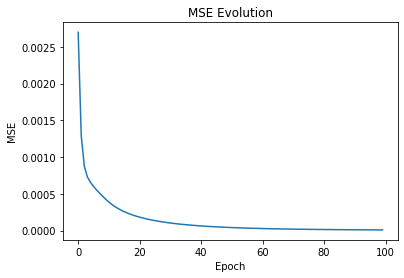

In [128]:
# Train and Test split
test_idx = np.sort(np.random.randint(0, 6000, size=1000))
X_test = X[test_idx]
y_test = y[test_idx]
X_train = []
y_train = []

for idx in range(6000):
    if idx not in test_idx:
        X_train.append(X[idx])
        y_train.append(y[idx])

X_train = np.array(X_train)
y_train = np.array(y_train)
        
# Anfis
model = Anfis(10, X_train.shape[1])
model.initialize_params(X = X_train)
model.fit(X_train, y_train, n_epochs=100, lr=0.01)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 4 - Previsão de uma série temporal caótica

## Geração de dados
Esse problema consiste em aproximação de uma série temporal caótica descrita pela seguinte função:

$\hat{x} = \frac{0.2x(t-\tau)}{1+x^{10}(t-\tau)} - 0.1x(t)$

As entradas desse problema são variáveis x(t), x(t-6), x(t-12) e x(t-18) e saída x(t+6). E esses dados x(t) foram obtidas da série temporal Mackey-Glass. Para a geração dos dados utilizou-se um intervalo de t=118 até 1117.

In [75]:
# code from: https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
def mackey_glass(sample_len=1000, tau=17, seed=None, n_samples = 1):
    delta_t = 10
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

serie = mackey_glass(sample_len=1130, tau=17, seed=None, n_samples = 1)[0]

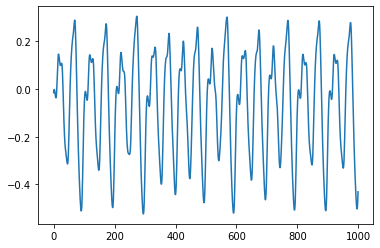

In [77]:
def x_hat(t, tau, x):
    x_hat = 0.2*x[t-tau]/(1+x^10*(t-tau))
    return x_hat

t = np.linspace(118, 1117, 1000)
X=[]
y=[]
for ti in t:
    x = [serie[int(ti)-18], serie[int(ti)-12], serie[int(ti)-6], serie[int(ti)]]
    X.append(x)
    y.append(serie[int(ti)+6])
plt.plot(y)

X = np.array(X)
y = np.array(y)

## Aplicação do Anfis desenvolvido

In [78]:
# Train and Test split
test_idx = np.sort(np.random.randint(0, 1000, size=100))
X_test = X[test_idx]
y_test = y[test_idx]
X_train = []
y_train = []

for idx in range(1000):
    if idx not in test_idx:
        X_train.append(X[idx])
        y_train.append(y[idx])

X_train = np.array(X_train)
y_train = np.array(y_train)

mse: 0.0008586199260914008


Text(0, 0.5, 'MSE')

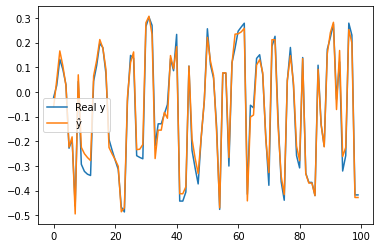

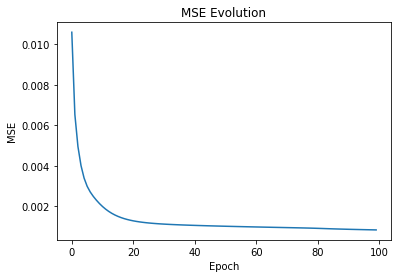

In [79]:
# Anfis
model = Anfis(n_rules = 16, n_inputs = 4)
model.initialize_params(X = X_train)
model.fit(X_train, y_train, n_epochs=100, lr=0.1)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 5 - Problema de Regressão de um Data Set da UCI.

O data set escolhido para este exercício foi o "Air Quality Data Set". Essa base de dados contém  9358 instâncias. Foram utilizadas 12 variáveis de entrada e a variável a ser prevista foi a humidade ralativa.

## Leitura e pré-processamento dos dados

In [120]:
dataset = pd.read_csv('data/AirQualityUCI.csv', sep=';')
dataset = dataset.replace("?", np.nan)
dataset = dataset.dropna()
dataset

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


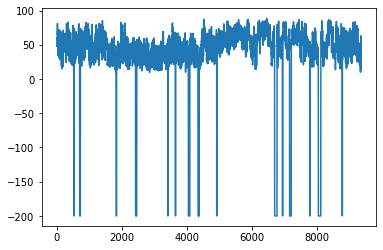

In [121]:
y = dataset['RH'].to_numpy()
X = dataset.drop(['RH', 'Date', 'Time'], axis='columns').to_numpy()
normalizer = MinMaxScaler()
X = normalizer.fit_transform(X)
y = np.array(y.tolist())
plt.plot(y)

## Aplicação do Anfis desenvolvido

mse: 104.87397516386146


Text(0, 0.5, 'MSE')

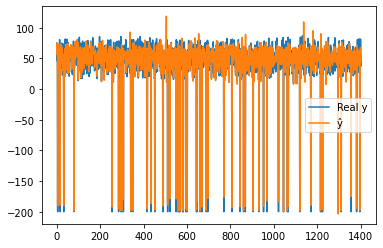

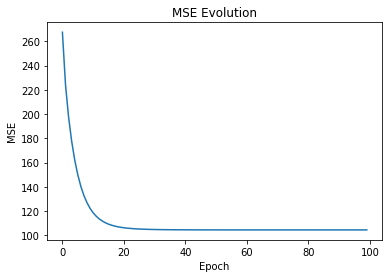

In [122]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Anfis
model = Anfis(n_rules = 12, n_inputs = X_train.shape[1])
model.initialize_params(X = X_train)
model.fit(X_train, y_train, n_epochs=100, lr=0.1)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [164]:
dataset = pd.read_csv('data/airfoil_self_noise.dat', sep='\t', header=None)
dataset = dataset.replace("?", np.nan)
dataset = dataset.dropna()
dataset

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Text(0.5, 1.0, '$Y_{test}$')

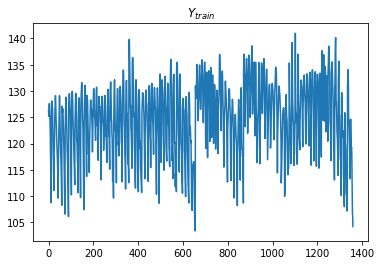

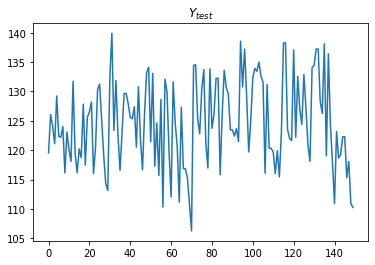

In [172]:
y = dataset[5].to_numpy()
X = dataset.drop([5], axis='columns').to_numpy()
normalizer = MinMaxScaler()
X = normalizer.fit_transform(X)
y = np.array(y.tolist())

test_idx = np.sort(np.random.randint(0, X.shape[0], size=int(X.shape[0]*0.1)))
X_test = X[test_idx]
y_test = y[test_idx]
X_train = []
y_train = []

for idx in range(X.shape[0]):
    if idx not in test_idx:
        X_train.append(X[idx])
        y_train.append(y[idx])
X_train = np.array(X_train)
y_train = np.array(y_train)

plt.plot(y_train)
plt.title('$Y_{train}$')
plt.figure()
plt.plot(y_test)
plt.title('$Y_{test}$')

mse: 23.887319353459194


Text(0, 0.5, 'MSE')

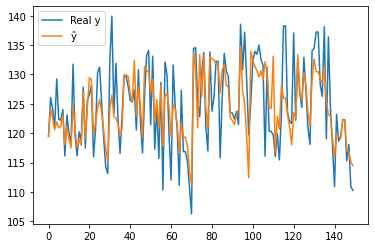

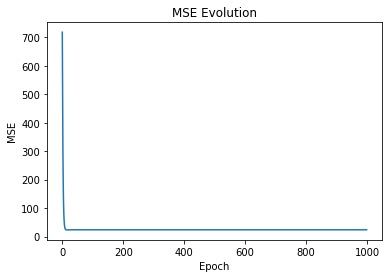

In [177]:
# Anfis
model = Anfis(n_rules = 5, n_inputs = X_train.shape[1])
model.initialize_params(X = X_train)
model.fit(X_train, y_train, n_epochs=1000, lr=0.03)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")